### **Overview**

This notebooks contains tools for preprocessing and visualization of the Walaris dataset for flight trajectories, given as Json files.


### To Do
- Add UAV vs all analysis?
- use segmentation summary dictionary as weights

### Imports and loading

In [2]:
# imports

import io
import os
import sys
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft
import pandas as pd
import seaborn as sns
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# prompt: Access a folder on google drive and import the data locally
from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions_full import *

Mounted at /content/drive/


In [3]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


In [4]:
# file_path = "Flight Track/uav/VIS_uav_20230605-108_20230605-130248.json"
# file_path = "Flight Track/bird/VIS_bird_20230605-406_20230605-142825.json"
# file_path = "Flight Track/bird/VIS_bird_20231024-22251_20231024-083633.json"
# file_path = "Flight Track/airplane/VIS_airplane_20231023-6210_20231023-162937.json"
# file_path = "Flight Track/airplane/VIS_airplane_20231025-21925_20231025-074948.json"
# file_path = "Flight Track/uav/VIS_uav_20231027-10903_20231027-114017.json"
# file_path = "Flight Track/uav/VIS_uav_20231027-11132_20231027-115333.json"
# file_path = "Flight Track/uav/VIS_uav_20231027-10582_20231027-113033.json"
# file_path = "Flight Track/uav/VIS_uav_20231030-6113_20231030-140702.json"
# file_path = "Flight Track/uav/VIS_uav_20231027-10437_20231027-112435.json"
# file_path = "track_data/uav/VIS_uav_20230605-108_20230605-130248.json"
# file_path = "track_data/bird/VIS_bird_20231116-20636_20231116-082324.json"
# plot_vs_time(file_path, 'vel')
# tt, xx, yy, zz, theta, phi, size_hor, size_ver, light_domain = raw_angles_data_from_json(file_path)
# plot_3d_and_2d_angles(file_path, start = 0, finish = -999)

### Segmentation

Assume interpolation of dt = 40 msec.\
For example: a sequence of 5 seconds is equivalent to 25*5 = 125

In [5]:
folder = 'track_data'

In [6]:
def segment_file_by_time(file_path, samples_config):
  sample_duration = samples_config['sample_duration']
  overlap_factor = samples_config['overlap_factor']
  tt, xx, yy, zz, theta, phi, size_hor, size_ver, light_domain = raw_angles_data_from_json(file_path)
  theta, phi = convert_to_angles(xx, yy, zz)
  xx, yy, zz = clean_3D_data_w_split(tt, xx, yy, zz, factor = 3, window = 5, threshold = -999)
  theta, phi = clean_2D_data_w_split(tt, theta, phi, factor = 3, window = 5, threshold = -999)
  complete_sample = np.stack([tt, xx, yy, zz, size_hor, size_ver]).T

  #segmenting
  skip = sample_duration * (1-overlap_factor)
  current_index = [0]
  end_index = np.nonzero(tt>=tt[0]+sample_duration)[0]

  sub_samples = []
  while end_index.size:
      # print(current_index[0], end_index[0])
      if end_index[0] - current_index[0] > samples_config['min_samples']: ### a threshold for a minimum number of datapoints in a sample
        sub_samples.append(complete_sample[current_index[0]:end_index[0], :])
      end_index = np.nonzero(tt>=tt[current_index[0]]+skip+sample_duration)[0]
      current_index = np.nonzero(tt>=tt[current_index[0]]+skip)[0]

  return sub_samples, light_domain

In [7]:
subfolders = os.listdir("track_data/")
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

### Extract samples

In [8]:
subf_dict

{0: 'airplane', 1: 'uav', 2: 'bird', 3: 'static-object'}

In [9]:
def extract_samples(folder, samples_config):
  subfolders = os.listdir(folder)
  subfolders_list = [subfolders[i] for i in samples_config['subfolders_ind']]

  samples_dict = {}
  samples_summary_dict = {}

  for subfolder in subfolders_list:
      print(subfolder)
      total_samples = 0
      subfolder_path = os.path.join(folder, subfolder)
      files = os.listdir(subfolder_path)
      for file in files:
          file_path = os.path.join(subfolder_path, file)
          sub_samples, light_domain = segment_file_by_time(file_path, samples_config)
          samples_dict[file] = sub_samples
          total_samples = total_samples + len(sub_samples)
      samples_summary_dict[subfolder] = total_samples
  print('samples summary:', samples_summary_dict)
  return samples_dict, samples_summary_dict

In [10]:
# samples_config = {
#     'sample_duration' : 15,
#     'overlap_factor' : 0.25,
#     'subfolders_ind' : [0, 1, 2, 3],
#     'min_samples' : 10
# }
# # sample_durations = [25]
# sample_durations = [3, 5, 10, 15, 20, 25]
# overlaps = [0, 0.25]
# for dur in sample_durations:
#   print('Sample Duration = ', dur)
#   samples_config['sample_duration'] = dur
#   for overlap in overlaps:
#     print('Overlap = ', overlap)
#     samples_config['overlap_factor'] = overlap

#     samples_dict, samples_summary_dict = extract_samples(folder, samples_config)
#     save_path = './Samples/samples_'+ str(dur) + 'ol' + str(overlap)
#     with open(save_path , 'wb') as f:
#         pickle.dump((samples_dict, samples_summary_dict), f)

## Helper transformations and feature functions (temp - to be moved to file)

In [11]:
def return_span(series):
  return series.max() - series.min()

In [12]:
def phi_theta_ratio(tt, data_theta, data_phi, pt_ratio_quants, dt=1, time_span = 3):
  """
  """
  new_tt = np.arange(tt[0], tt[-1]+dt, dt)

  interp_data_theta = np.interp(new_tt, tt, data_theta)
  pd_data_theta = pd.Series(interp_data_theta)
  rolling_data_theta = pd_data_theta.rolling(time_span)
  span_theta = rolling_data_theta.apply(return_span)

  interp_data_phi = np.interp(new_tt, tt, data_phi)
  pd_data_phi = pd.Series(interp_data_phi)
  rolling_data_phi = pd_data_phi.rolling(time_span)
  span_phi = rolling_data_phi.apply(return_span)
  span_ratios = np.arctan(span_phi/span_theta)
  span_ratios = span_ratios[~np.isnan(span_ratios)]
  span_ratios_quant = np.quantile(span_ratios, pt_ratio_quants)

  return span_ratios.min(), span_ratios.max(), span_ratios_quant

In [13]:
def PCA_angles_transformation(theta, phi):
  """returns the data, rotated so that the principle axis of the data in the xy plane is on x
  """
  tp_data = np.stack([theta, phi]).T

  pca = PCA(n_components=2, svd_solver='full')
  angles_projected = pca.fit_transform(tp_data)

  return angles_projected[:,0], angles_projected[:,1]
  # new_theta, new_phi = PCA_angles_transformation(cleaned_theta, cleaned_phi)

In [14]:
def angle_span_ratios(theta, phi):
  orig_ratio = (phi.max() - phi.min())/(theta.max() - theta.min())
  pca_theta, pca_phi = PCA_angles_transformation(theta, phi)
  pca_ratio = (pca_phi.max() - pca_phi.min())/(pca_theta.max() - pca_theta.min())
  return orig_ratio, pca_ratio

In [15]:
def smoothed(data, window = 5):
  """
  Args:
    data: A one dimensional array of data.
    window: The window of the convolution used for low-pass filtering.

  Returns:
    A smoothed version of the data
  """
  # Run a low pass filter.
  padded_data = np.pad(data, (window//2, window//2), 'edge')
  smooth_data = np.convolve(padded_data, np.ones(window) / window, mode='valid')
  return smooth_data

In [16]:
def derive(theta_data, phi_data, time):
  t_der = (time[:-1] + time[1:])/2
  der_theta = np.diff(theta_data)/np.diff(time)
  inf_ind1 = np.where(np.isinf(der_theta))
  nan_ind1 = np.where(np.isnan(der_theta))
  der_phi = np.diff(phi_data)/np.diff(time)
  inf_ind2 = np.where(np.isinf(der_phi))
  nan_ind2 = np.where(np.isnan(der_phi))
  inf_inds = np.union1d(inf_ind1, inf_ind2)
  nan_inds = np.union1d(nan_ind1, nan_ind2)
  inds = np.union1d(inf_inds, nan_inds)
  mask = np.ones(len(t_der), dtype=bool)
  mask[inds] = False

  return der_theta[mask], der_phi[mask], t_der[mask]

### Extract features

In [17]:
  t1 = np.arange(2, 5, 0.04)
  t2 = np.arange(5, 6, 0.04)
  part1 = (0.5/5**2)*t1**2 + 0.5
  part2 = 1 - 0.5*(t2-5)
  filt1 = np.flip(np.hstack([part1, part2]))
  t4 = np.arange(-5, -2, 0.04)
  t3 = np.arange(-6, -5, 0.04)
  part3 = -1 - 0.5*(t3+5)
  part4 = -(0.5/5**2)*t4**2 - 0.5
  filt2 = np.flip(np.hstack([part3, part4]))

In [18]:
def extract_features(sample):
  tt, xx, yy, zz, size_hor, size_ver = sample[:, 0], sample[:, 1], sample[:, 2], sample[:, 3], sample[:, 4], sample[:, 5]
  theta, phi = convert_to_angles(xx, yy, zz)
  # Basic transformations
  #standerdizing to start from 0
  phi = phi - phi[0]
  theta = theta - theta[0]
  # clean
  # xx, yy, zz = clean_3D_data_w_split(tt, xx, yy, zz, factor = 3, window = 5, threshold = -999)
  theta, phi = clean_2D_data_w_split(tt, theta, phi, factor = 3, window = 5, threshold = -999, replace_by = 'med')

  # interpolate
  delta = 0.04
  interp_tt, interp_theta = interpolate_data(tt, theta, dt=delta, fixed = False)
  interp_tt, interp_phi = interpolate_data(tt, phi, dt=delta, fixed = False)
  # interp_tt, interp_xx = interpolate_data(tt, xx, dt=delta, fixed = False)
  # interp_tt, interp_yy = interpolate_data(tt, yy, dt=delta, fixed = False)
  # interp_tt, interp_zz = interpolate_data(tt, zz, dt=delta, fixed = False)
  interp_tt, interp_size_hor = interpolate_data(tt, size_hor, dt=delta, fixed = False)
  interp_tt, interp_size_ver = interpolate_data(tt, size_ver, dt=delta, fixed = False)
  fix_interp_tt, fix_interp_theta = interpolate_data(tt, theta, dt=delta, fixed = True)
  fix_interp_tt, fix_interp_phi = interpolate_data(tt, phi, dt=delta, fixed = True)

  # derive
  interp_vel_theta, interp_vel_phi, interp_t_vel = derive(interp_theta, interp_phi, interp_tt)
  vel_theta, vel_phi, t_vel = derive(theta, phi, tt)
  abs_vel = np.sqrt(vel_theta**2 + vel_phi**2)
  acc_theta, acc_phi, t_acc = derive(vel_theta, vel_phi, t_vel)
  abs_acc = np.sqrt(acc_theta**2 + acc_phi**2)
  fix_vel_theta, fix_vel_phi, t_vel = derive(fix_interp_theta, fix_interp_phi, fix_interp_tt)

  # rolling window smoothing
  s_theta = smoothed(theta, window = 5)
  s_phi = smoothed(phi, window = 5)
  delta = 0.04
  # interp_tt, s_interp_theta = interpolate_data(tt, s_theta, dt=delta, fixed = False)
  # interp_tt, s_interp_phi = interpolate_data(tt, s_phi, dt=delta, fixed = False)
  # s_vel_theta = np.diff(s_interp_theta)/np.diff(interp_tt)
  # s_vel_phi = np.diff(s_interp_phi)/np.diff(interp_tt)
  # s_abs_vel = np.sqrt(s_vel_theta**2 + s_vel_phi**2)
  s_vel_theta, s_vel_phi, s_t_vel = derive(s_theta, s_phi, tt)
  s_abs_vel = np.sqrt(s_vel_theta**2 + s_vel_phi**2)
  s_vel_theta, s_vel_phi, s_t_vel = derive(s_theta, s_phi, tt)
  s_abs_vel = np.sqrt(s_vel_theta**2 + s_vel_phi**2)
  s_acc_theta, s_acc_phi, s_t_acc = derive(s_vel_theta, s_vel_phi, s_t_vel)
  s_abs_acc = np.sqrt(s_acc_theta**2 + s_acc_phi**2)

  # FEATURES
  returning_features = []
  feature_names = []
  # extreme values (scale dependent)
  max_size_hor = size_hor.max()
  max_size_ver = size_ver.max()
  max_elevation = phi.max()
  min_elevation = phi.min()
  max_theta_vel =  np.abs(vel_theta).max()
  max_phi_vel =  np.abs(vel_phi).max()
  max_vel = abs_vel.max()
  max_theta_acc =  np.abs(acc_theta).max()
  max_phi_acc =  np.abs(acc_phi).max()
  max_acc = abs_acc.max()
  returning_features.extend([max_elevation, min_elevation, max_theta_vel, max_phi_vel, max_vel, max_theta_acc, max_phi_acc, max_acc])
  feature_names.extend(['max_elevation', 'min_elevation', 'max_theta_vel', 'max_phi_vel', 'max_vel', 'max_theta_acc', 'max_phi_acc', 'max_acc'])

  s_max_elevation = s_phi.max()
  s_min_elevation = s_phi.min()
  s_max_theta_vel = np.abs(s_vel_theta).max()
  s_max_phi_vel = np.abs(s_vel_phi).max()
  s_max_vel = s_abs_vel.max()
  s_med_vel = np.median(s_abs_vel)
  s_max_theta_acc = np.abs(s_acc_theta).max()
  s_max_phi_acc = np.abs(s_acc_phi).max()
  s_max_acc = s_abs_acc.max()
  s_med_acc = np.median(s_abs_acc)
  returning_features.extend([s_max_elevation, s_min_elevation, s_max_theta_vel, s_max_phi_vel, s_max_vel, s_max_theta_acc, s_max_phi_acc, s_max_acc])
  feature_names.extend(['s_max_elevation', 's_min_elevation', 's_max_theta_vel', 's_max_phi_vel', 's_max_vel', 's_max_theta_acc', 's_max_phi_acc', 's_max_acc'])

  # statistics and noise
  theta_std = local_std(interp_theta, window = 10)
  phi_std = local_std(interp_phi, window = 10)
  theta_vel_std = local_std(interp_vel_theta, window = 10)
  phi_vel_std = local_std(interp_vel_phi, window = 10)
  returning_features.extend([theta_std, phi_std, theta_vel_std, phi_vel_std])
  feature_names.extend(['theta_std', 'phi_std', 'theta_vel_std', 'phi_vel_std'])

  # span
  theta_span = theta.max() - theta.min()
  phi_span = phi.max() - phi.min()
  returning_features.extend([theta_span, phi_span])
  feature_names.extend(['theta_span', 'phi_span'])

  # avg values
  med_elevation = np.median(phi)
  med_size_hor = np.median(size_hor)
  med_size_ver = np.median(size_ver)
  med_theta_vel =  np.median(vel_theta)
  med_phi_vel =  np.median(vel_phi)
  med_theta_acc =  np.median(acc_theta)
  med_phi_acc =  np.median(acc_phi)
  returning_features.extend([med_elevation, med_theta_vel, med_phi_vel, med_theta_acc, med_phi_acc, s_med_vel, s_med_acc])
  feature_names.extend(['med_elevation', 'med_theta_vel', 'med_phi_vel', 'med_theta_acc', 'med_phi_acc', 's_med_vel', 's_med_acc'])

  # Bounding box data
  returning_features.extend([max_size_hor, max_size_ver, med_size_hor, med_size_ver])
  feature_names.extend(['max_size_hor', 'max_size_ver', 'med_size_hor', 'med_size_ver'])


  # correlations
  # print(np.any(np.isinf(vel_theta)), np.any(np.isinf(vel_phi)))
  ascending_sig = np.max(np.convolve(fix_vel_phi/fix_vel_phi.max(), filt1, mode='valid'))
  decending_sig = np.max(np.convolve(fix_vel_phi/fix_vel_phi.min(), filt2, mode='valid'))

  pt_vel_corr, _ = pearsonr(np.abs(vel_theta), np.abs(vel_phi))
  pt_acc_corr, _ = pearsonr(np.abs(acc_theta), np.abs(acc_phi))

  returning_features.extend([ascending_sig, decending_sig, pt_vel_corr, pt_acc_corr])
  feature_names.extend(['ascending_sig', 'decending_sig', 'pt_vel_corr', 'pt_acc_corr'])

  # FFT

  # yf = fft(fix_vel_phi)
  # yf_trimmed_abs = np.abs(yf[0:len(yf)//2+1])

  # ratios
  orig_ratio, pca_ratio = angle_span_ratios(theta, phi)
  std_vs_span = np.sqrt((theta_std**2 + phi_std**2)/(theta_span**2 + phi_span**2))
  returning_features.extend([orig_ratio, pca_ratio, std_vs_span])
  feature_names.extend(['orig_ratio', 'pca_ratio', 'std_vs_span'])

  # scale independent features
  # measuring geometric curvature

  discrete_angle_dist = np.sqrt(np.diff(interp_theta)**2 + np.diff(interp_phi)**2)
  cumsum_angles_dist = np.cumsum(discrete_angle_dist)
  path_total_length = cumsum_angles_dist[-1]
  cum_dist = np.hstack([0, cumsum_angles_dist])

  angles = np.stack([interp_theta, interp_phi]).T
  eucl_dist = cdist(angles, angles, 'euclidean') + np.ones([len(interp_theta), len(interp_theta)])*1e-6 #added to avoid devision by 0

  path_dist = np.abs(cum_dist[:, None] - cum_dist)
  dist_ratio = path_dist/eucl_dist
  distance_buffer = 5 #removing ratios of points close to one another, since this may be noisy
  all_curve_ratios = sum((dist_ratio[i,i+distance_buffer:].tolist() for i in range(dist_ratio.shape[0])), [])
  curve_quants = np.arange(0.1, 0.95, 0.1)
  curve_quantiles = np.quantile(all_curve_ratios, curve_quants)
  max_curve_ratio = np.max(all_curve_ratios)
  returning_features.extend([*curve_quantiles, max_curve_ratio])
  q_names = ['curve quant ' + str(round(q, 2)) for q in curve_quants]
  feature_names.extend(q_names + ['max_curve_ratio'])

  # measuring angles ratios (quantiles):
  # e.g. object rising fast without changing azimuth, or changing azimuth without elevation
  pt_ratio_quants = np.arange(0.1, 0.95, 0.1)
  min_span_ratios, max_span_ratios, span_ratios_quant = phi_theta_ratio(tt, theta, phi, pt_ratio_quants, dt=1, time_span = 3)
  returning_features.extend([*span_ratios_quant, max_span_ratios, min_span_ratios])
  q_names = ['pt ratio quant ' + str(round(q, 2)) for q in pt_ratio_quants]
  feature_names.extend(q_names + ['max_span_ratios', 'min_span_ratios'])

  # velocity and acceleration profiles (ratios)
  motion_quants = np.arange(0.1, 0.95, 0.1)
  vel_quantiles = np.quantile(s_abs_vel, motion_quants)
  vel_profile = vel_quantiles/s_med_vel
  acc_quantiles = np.quantile(s_abs_acc, motion_quants)
  acc_profile = acc_quantiles/s_med_acc
  q_vel_names = ['vel quant ' + str(round(q, 2)) for q in motion_quants]
  q_acc_names = ['acc quant ' + str(round(q, 2)) for q in motion_quants]
  returning_features.extend([*vel_profile, *acc_profile])
  feature_names.extend(q_vel_names + q_acc_names)

  return returning_features, feature_names

### Prepare dataset

In [19]:
def prepare_dataset(split_config):
  print('collecting samples')
  # subfolders_list = [subf_dict[i] for i in split_config['subfolders_ind']]
  subfolders_list = [subf_dict[i] for i in np.arange(4)]
  save_path = './Samples/samples_'+ str(split_config['sample_duration']) + 'ol' + str(split_config['overlap_factor'])
  with open(save_path , 'rb') as f:
    samples_dict, samples_summary_dict = pickle.load(f)

  # files_labels = []
  all_samples = []
  samples_labels = []
  samples_filenames = []
  samples_light = []
  database_summary_dict = {}

  for subfolder in subfolders_list:
    subfolder_path = os.path.join(folder, subfolder)
    files = os.listdir(subfolder_path) # Can also be taken from samples_dict keys
    # files_labels.extend([labels_dict[subfolder]]*len(files))
    n_subfolder_samples = 0
    for file in files:
      light_domain = file[:3]
      sub_samples = samples_dict[file]
      all_samples.extend(sub_samples)
      sub_labels = [labels_dict[subfolder]]*len(sub_samples)
      samples_labels.extend(sub_labels)
      sub_light = [light_domain]*len(sub_samples)
      samples_light.extend(sub_light)
      sub_file = [file]*len(sub_samples)
      samples_filenames.extend(sub_file)
      n_subfolder_samples = n_subfolder_samples + len(sub_samples)
    database_summary_dict[subfolder] = n_subfolder_samples
  print('extracting features')
  data = []
  for i, sample in enumerate(all_samples):
    data_row, features = extract_features(sample)
    data.append(data_row)

  df = pd.DataFrame(data, columns=features)
  df['light'] = samples_light
  df['file'] = samples_filenames
  df['label'] = samples_labels

  print('Done')
  return df, features

### Split

In [20]:
def split_by_files(df, df0, split_config):
  files = np.unique(df['file'].values)
  files_ind = [np.where(df['file'].values == f)[0][0] for f in files]
  files_labels = df['label'].values[files_ind]
  rs = split_config['random_state']
  ts = split_config['test_split_files']
  files_train, files_test = train_test_split(files, test_size=ts, random_state=rs, stratify=files_labels)
  train_df = df[df['file'].isin(files_train)]
  test_df = df0[df0['file'].isin(files_test)]
  return train_df, test_df

In [21]:
print(labels_dict)
print(subf_dict)

{'airplane': 0, 'uav': 1, 'bird': 2, 'static-object': 3}
{0: 'airplane', 1: 'uav', 2: 'bird', 3: 'static-object'}


### Evaluation

In [22]:
def evaluate(labels, predictions, caption, plot_cm , print_scores):

  classes = np.union1d(labels, predictions)
  tick_names = [subf_dict[c] for c in classes]
  # Confusion Matrix - Multi class
  cm = confusion_matrix(labels, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=tick_names)
  if plot_cm:
    disp.plot()
    disp.ax_.set_title(caption)
    plt.show()

  # Scores #
  # f1_s = f1_score(labels, predictions, sample_weight=None, average = 'weighted', zero_division='warn')
  report = classification_report(labels, predictions, target_names = tick_names, output_dict=True, digits=3, zero_division = 0)

  f1_all = report['weighted avg']['f1-score']

  if print_scores == True:
      print(classification_report(labels, predictions, target_names = tick_names,digits=3, zero_division = 0))
      # print(f1_s)
      print('Average F1 score for all classes = ', f1_all)
      print('------------------------')
      print('UAV report')
      print('------------------------')
      print('precision = ', report['uav']['precision'])
      print('recall = ', report['uav']['recall'])
      print('F1 = ', report['uav']['f1-score'])
      print('support = ', report['uav']['support'])

  return report

## Experiments

In [23]:
# record_columns = ['datetime', 'Sample Duration', 'Test Files', 'Split Config', 'Features Config', 'Model', 'Model Config', 'Evaluation Report', 'UAV precision', 'UAV recall', 'UAV f1', 'Total f1']
# exp_record = pd.DataFrame(columns = record_columns)

In [24]:
def conf2str(split_config, features_config):
  conf_str = 'sd' + str(split_config['sample_duration']) \
  +'of' + str(split_config['overlap_factor']) \
  +'ms' + str(split_config['min_samples']) \
  +'f_date' + str(features_config['date'])
  return conf_str

In [25]:
features_dict = {
    'extremum' : np.arange(0,16),
    'std' : np.arange(16,20),
    'span' : np.arange(20,22),
    'med' : np.arange(22,29),
    'bbox' : np.arange(29,33),
    'corr_sig' : np.arange(33,37),
    'full_ratio' : np.arange(37,40),
    'curve' : np.arange(40,50),
    'pt_ratio' : np.arange(50,61),
    'vel_acc_profile' : np.arange(61,79)
}

In [26]:
def get_datasets(split_config, features_config):
  conf_str = conf2str(split_config, features_config)
  database_path = './Features Databases/database_'+ conf_str
  if os.path.isfile(database_path):
    with open(database_path , 'rb') as f:
      df, features = pickle.load(f)
      # print('Loading dataset')
  else:
    df, features = prepare_dataset(split_config)
    with open(database_path , 'wb') as f:
      pickle.dump((df, features), f)

  #retrieving 0 overlap matching df
  ol0_config = split_config.copy()
  ol0_config['overlap_factor'] = 0
  conf_str = conf2str(ol0_config, features_config)

  database0_path = './Features Databases/database_'+ conf_str
  if os.path.isfile(database0_path):
    with open(database0_path , 'rb') as f:
      df0, features = pickle.load(f)
      # print('Loading dataset')
  else:
    df0, features = prepare_dataset(ol0_config)
    with open(database0_path , 'wb') as f:
      pickle.dump((df0, features), f)
  return df, df0, features

In [29]:
record_columns = ['datetime', 'Sample Duration', 'Test Files', 'Split Config', 'Features Config', 'Model', 'Model Config', 'Evaluation Report', 'UAV precision', 'UAV recall', 'UAV f1', 'Total f1']
exp_record = pd.DataFrame(columns = record_columns)

split_config = {
    'sample_duration' : 15,
    'overlap_factor' : 0.25,
    'subfolders_ind' : [0, 1, 2, 3],
    'min_samples' : 10,
    'random_state' : 24,
    'test_split_files' : 0.2, # 2 for n files
    'kfold' : 5
  }

features_config = {
    'date' : 20_1_2024,
    'extremum' : True,
    'std' : True,
    'span' : True,
    'med' : True,
    'bbox' : True,
    'corr_sig' : True,
    'full_ratio' : True,
    'curve' : True,
    'pt_ratio' : True,
    'vel_acc_profile' : True
  }

rf_config = {
    'max_depth' : 10,
    'model_random_state' : 42
  }

# split_random_states = [32]
# sample_durations = [20]
# max_depth = [10]

# model_random_states = [24, 32, 42]
# split_random_states = [24, 32, 42]
# sample_durations = [5, 10, 15, 20, 25]
# max_depth = [5, 7, 10, None]

model_random_states = [24]
split_random_states = [42]
sample_durations = [25]
max_depth = [None]

model_name = 'RF'
model_config = rf_config
now = datetime.now()
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
for mrs in model_random_states:
  model_config['model_random_state'] = mrs
  for rs in split_random_states:
    split_config['random_state'] = rs
    for dur in sample_durations:
      split_config['sample_duration'] = dur
      for depth in max_depth:
        model_config['max_depth'] = depth
        # print(split_config)
        # print(model_config)
        #Don't change split_config beyond this point
        df, df0, features = get_datasets(split_config, features_config)
        train_df, test_df = split_by_files(df, df0, split_config)

        feature_columns = np.empty(0)
        for key in features_config.keys():
          if features_config[key] == True:
            feature_columns = np.hstack([feature_columns, features_dict[key]])

        # train_df = train_df_0.sample(frac = 1, random_state = model_config['model_random_state']) #shuffled df (note - same rs as the model)
        train_df = train_df[train_df['label'].isin(split_config['subfolders_ind'])] # removing the folders we don't want to analyze (in split_config)
        train_df = train_df.sample(frac = 1, random_state = model_config['model_random_state']) #shuffled df (note - same rs as the model)
        train = train_df.iloc[:, feature_columns].values
        test_df = test_df[test_df['label'].isin(split_config['subfolders_ind'])] # removing the folders we don't want to analyze (in split_config)
        test = test_df.iloc[:, feature_columns].values
        train_labels = train_df['label'].values
        test_labels = test_df['label'].values

        #kfold cross validation
        # splitting needs to be done according to filenames to not have train and val samples from the same file
        files = np.unique(train_df['file'].values)
        files_ind = [np.where(train_df['file'].values == f)[0][0] for f in files]
        files_labels = train_df['label'].values[files_ind]
        # use stratified Kfold for imbalance handling
        skf = StratifiedKFold(n_splits=split_config['kfold'])
        skfold_ind = skf.split(files, files_labels)
        uav_precision = []
        uav_recall = []
        uav_f1 = []
        weighted_f1 = []
        for (train_ind, val_ind) in skfold_ind:
          train_files = files[train_ind]
          k_train_df = train_df[train_df['file'].isin(train_files)]
          k_train_df = k_train_df.sample(frac = 1, random_state = model_config['model_random_state']) #shuffled df (note - same rs as the model)
          k_train_labels = k_train_df['label'].values
          k_train = k_train_df.iloc[:, feature_columns].values

          val_files = files[val_ind]
          k_val_df = df0[df0['file'].isin(val_files)] # taking calculations from samples without overlap
          k_val_df = k_val_df.sample(frac = 1, random_state = model_config['model_random_state']) #shuffled df (note - same rs as the model)
          k_val_labels = k_val_df['label'].values
          k_val = k_val_df.iloc[:, feature_columns].values

          if model_name == 'RF':
            rf = RandomForestClassifier(max_depth=model_config['max_depth'], random_state=model_config['model_random_state'], class_weight = 'balanced')
            rf.fit(k_train, k_train_labels)
            k_predictions = rf.predict(k_val)

          k_report = evaluate(k_val_labels, k_predictions, model_name+'_depth_'+str(model_config['max_depth']), False , False)
          uav_precision.append(k_report['uav']['precision'])
          uav_recall.append(k_report['uav']['recall'])
          uav_f1.append(k_report['uav']['f1-score'])
          weighted_f1.append(k_report['weighted avg']['f1-score'])

        uav_precision_m = sum(uav_precision)/len(uav_precision)
        uav_recall_m = sum(uav_recall)/len(uav_recall)
        uav_f1_m = sum(uav_f1)/len(uav_f1)
        weighted_f1_m = sum(weighted_f1)/len(weighted_f1)

        # print('Fitting all train and test evaluation')
        if model_name == 'RF':
          rf = RandomForestClassifier(max_depth=model_config['max_depth'], random_state=model_config['model_random_state'])
          rf.fit(train, train_labels)
          predictions = rf.predict(test)
          test_report = evaluate(test_labels, predictions, model_name+'_depth_'+str(model_config['max_depth']), False , False)

        wrong_ind = np.where(predictions != test_labels)
        print('wrong on:')
        wrong_files = np.unique(test_df['file'].iloc[wrong_ind])
        print(wrong_files)
        # print(test_df['file'].iloc[wrong_ind])
        test_files = np.unique(test_df['file'])

        exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(),
                          test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

wrong on:
['VIS_airplane_20231023-4970_20231023-155314.json'
 'VIS_airplane_20231023-6210_20231023-162937.json'
 'VIS_airplane_20231025-21551_20231025-073653.json'
 'VIS_bird_20231116-21355_20231116-143608.json'
 'VIS_static-object_20231023-4609_20231023-153743.json'
 'VIS_uav_20231030-6479_20231030-142644.json']


In [ ]:
# date_time_ = str(date_time).replace("/","_")
# results_path = './Features Extraction Results/features_extraction_results_' + date_time_

# with open(results_path , 'wb') as f:
#   pickle.dump(exp_record, f)

In [38]:
type(files_labels[0])

numpy.int64

In [30]:
exp_record

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,UAV f1,Total f1
0,"02/04/2024, 09:40:42",25,[NIR_airplane_20231024-7069_20231024-021810.js...,"{'sample_duration': 25, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",RF,"{'max_depth': None, 'model_random_state': 24}","{'airplane': {'precision': 0.9642857142857143,...",0.848282,0.911871,0.869506,0.924833


In [31]:
test_df['file'].iloc[wrong_ind]

5        VIS_airplane_20231023-4970_20231023-155314.json
6        VIS_airplane_20231023-4970_20231023-155314.json
7        VIS_airplane_20231023-4970_20231023-155314.json
8        VIS_airplane_20231023-6210_20231023-162937.json
9        VIS_airplane_20231023-6210_20231023-162937.json
110     VIS_airplane_20231025-21551_20231025-073653.json
141           VIS_uav_20231030-6479_20231030-142644.json
331         VIS_bird_20231116-21355_20231116-143608.json
345    VIS_static-object_20231023-4609_20231023-15374...
Name: file, dtype: object

In [32]:
print(wrong_files)

['VIS_airplane_20231023-4970_20231023-155314.json'
 'VIS_airplane_20231023-6210_20231023-162937.json'
 'VIS_airplane_20231025-21551_20231025-073653.json'
 'VIS_bird_20231116-21355_20231116-143608.json'
 'VIS_static-object_20231023-4609_20231023-153743.json'
 'VIS_uav_20231030-6479_20231030-142644.json']


In [33]:
def plot_files(files, plot_type = 'full'):
    """
    print the requested plot_type for all files in the list
    5 type of plots:
    3D : 'raw'
    2D : 'cleaned'
         'full' = cleaned and interpolated
         'vel' - the time derivative of the phi angle
         'acc' - the time 2nd derivative of the phi angle
    """
    p = np.floor(np.sqrt(len(files))).astype(int)+1
    fig, axs = plt.subplots(figsize = [15,20])
    for j, file in enumerate(files, start = 1):
        subfolder = file.split('_')[1]
        subfolder_path = os.path.join("track_data", subfolder)
        file_path = os.path.join(subfolder_path, file)
        if plot_type == 'raw':
          ax = fig.add_subplot(p, p, j, projection='3d')
        else:
          ax = fig.add_subplot(p, p, j)
        plot_file(file_path, plot_type, ax)
        ax.set_title(subfolder + ' ' +file[-11:-5])
    fig.tight_layout()
    plt.show()

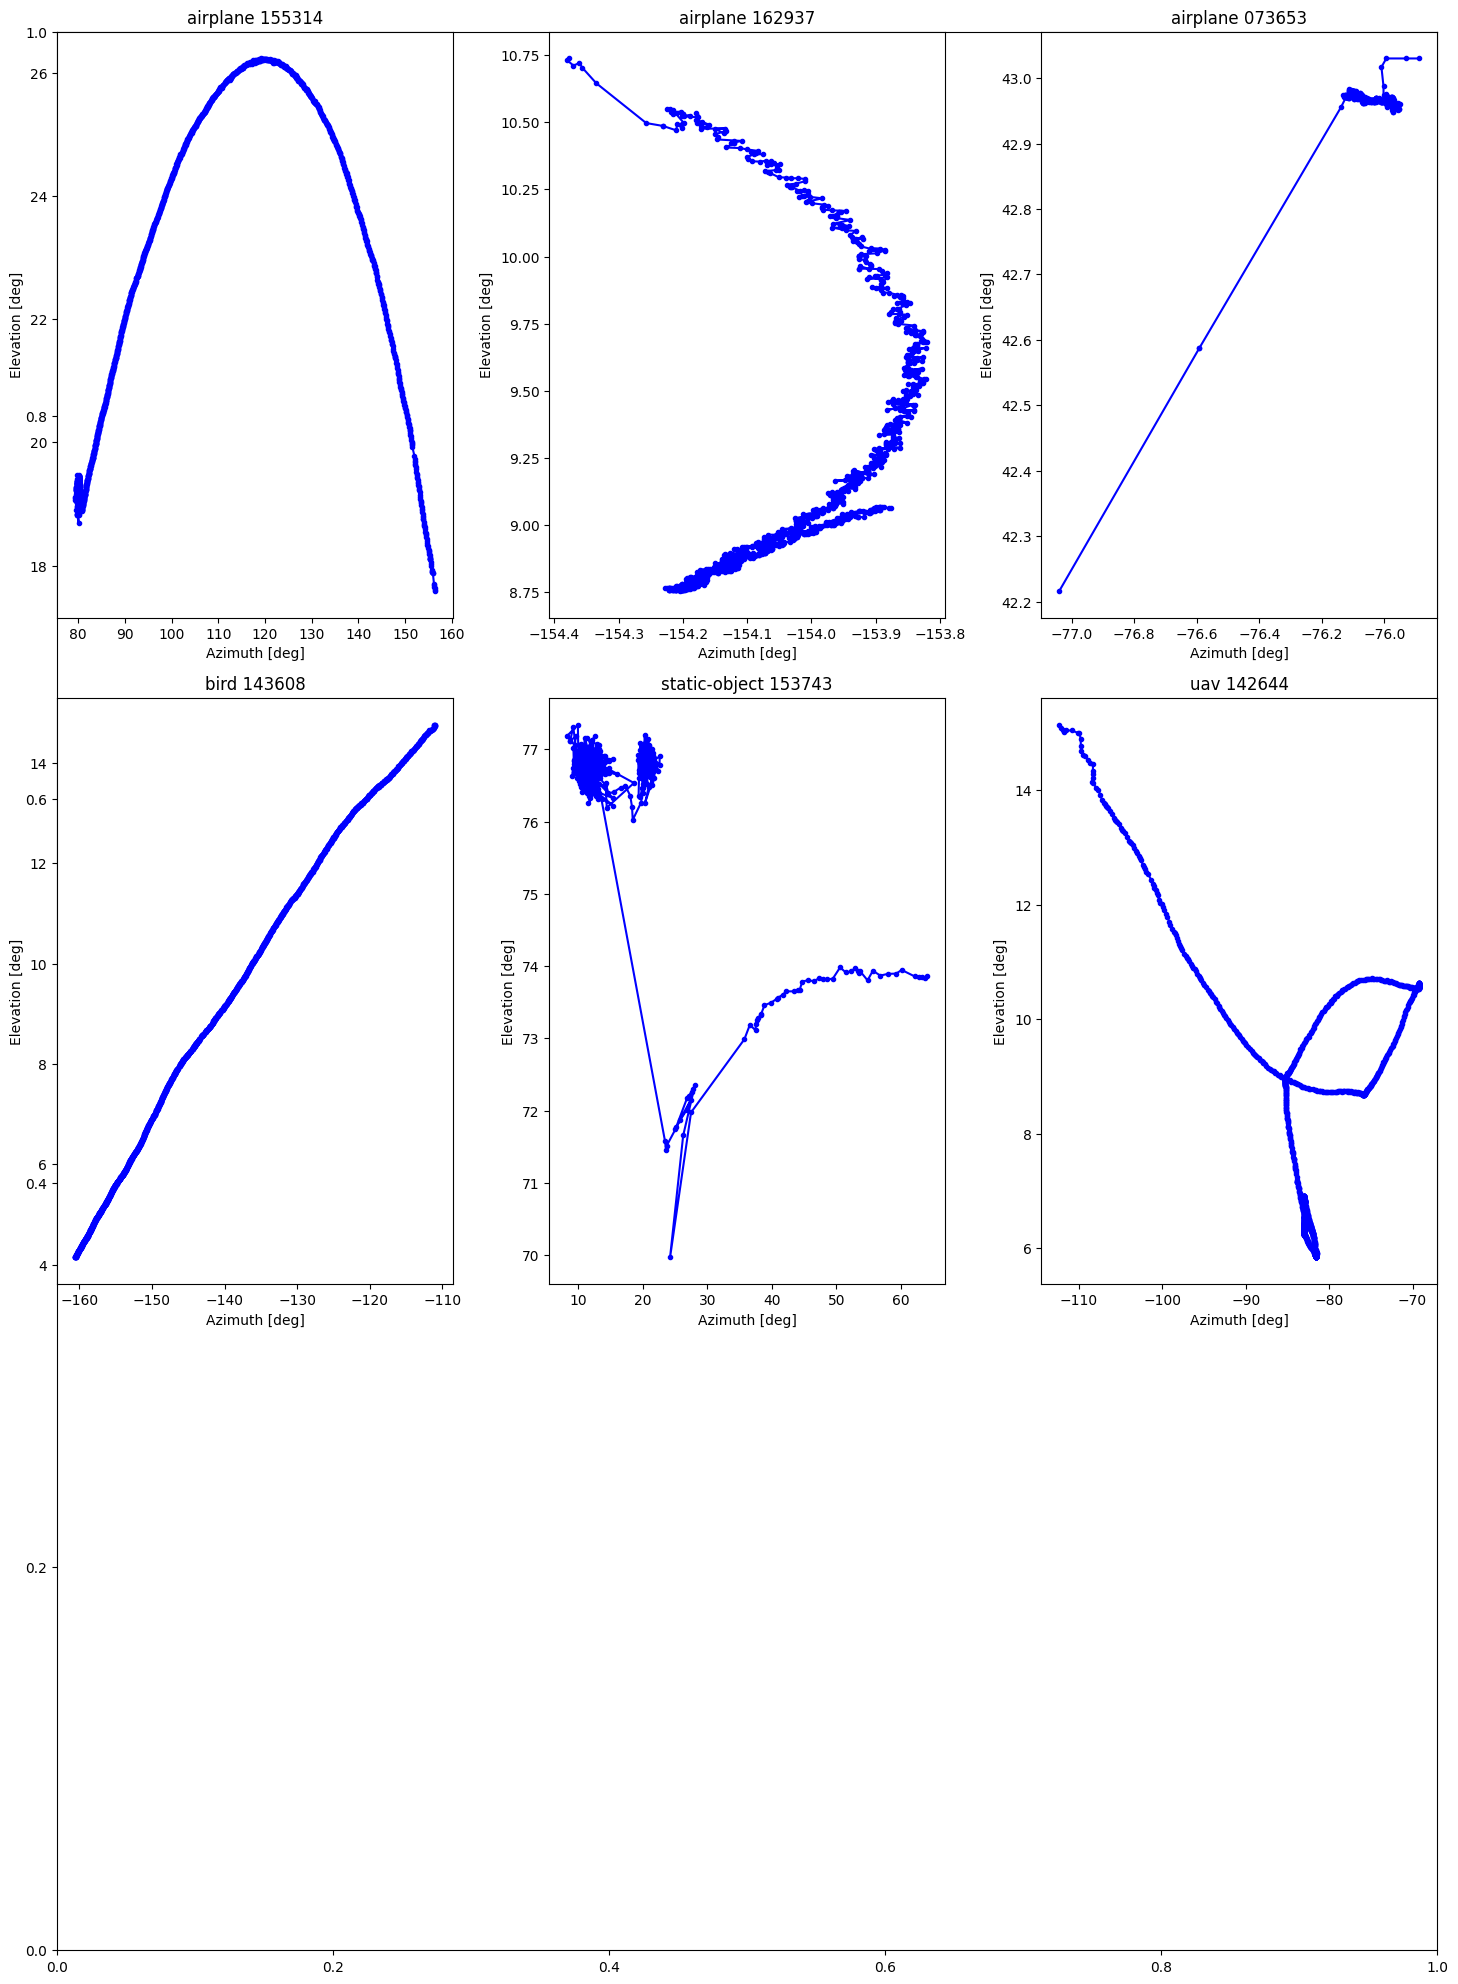

In [34]:
plot_files(wrong_files, 'cleaned')

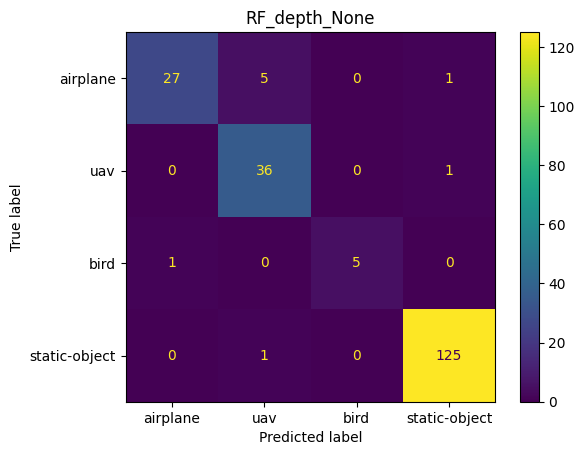

               precision    recall  f1-score   support

     airplane      0.964     0.818     0.885        33
          uav      0.857     0.973     0.911        37
         bird      1.000     0.833     0.909         6
static-object      0.984     0.992     0.988       126

     accuracy                          0.955       202
    macro avg      0.951     0.904     0.923       202
 weighted avg      0.958     0.955     0.955       202

Average F1 score for all classes =  0.9549262774739631
------------------------
UAV report
------------------------
precision =  0.8571428571428571
recall =  0.972972972972973
F1 =  0.9113924050632912
support =  37


In [35]:
test_report = evaluate(test_labels, predictions, model_name+'_depth_'+str(model_config['max_depth']), True , True)

### Sample visualization

In [36]:
def sample_visualization(sample, start = 0, finish = -999):
  """
  Plots the different preprocessing stages for a single file
  Zoom into the plot by specifying the start and end indices
  """
  tt, xx, yy, zz, size_hor, size_ver = sample[:, 0], sample[:, 1], sample[:, 2], sample[:, 3], sample[:, 4], sample[:, 5]
  theta, phi = convert_to_angles(xx, yy, zz)

  if finish == -999:
      start = 0
      finish = len(tt)

  fig = plt.figure(figsize = [10,10])
  ax1 = fig.add_subplot(2, 2, 1, projection='3d')
  ax1.plot(xx[start:finish], yy[start:finish], zz[start:finish], '.-b', label='Position')
  ax1.set_title('Raw xyz Data')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.set_zlabel('z')
  plt.legend()
  #plot cleaned data
  cleaned_theta, cleaned_phi = clean_2D_data_w_split(tt, theta, phi, factor = 3, window = 5, threshold = -999)

  ax2 = fig.add_subplot(2, 2, 2)
  ax2.plot(cleaned_theta[start:finish], cleaned_phi[start:finish], '.-g', label='Angles')
  ax2.set_title('Cleaned Angles Data')
  ax2.set_xlabel('Azimuth [deg]')
  ax2.set_ylabel('Elevation [deg]')
  plt.legend()
  #plot interpolation
  delta = 0.04
  new_tt, interp_theta = interpolate_data(tt, cleaned_theta, dt=delta, fixed = False)
  new_tt, interp_phi = interpolate_data(tt, cleaned_phi, dt=delta, fixed = False)

  #to plot the same span as not interpolated - find the right time marker
  new_finish = np.nonzero(new_tt>=tt[finish-1])[0][0]
  ax3 = fig.add_subplot(2, 2, 3)
  ax3.plot(interp_theta[start:new_finish], interp_phi[start:new_finish], '.-r', label='Interploated angles')
  ax3.set_title('Interpolated Data')
  ax3.set_xlabel('Azimuth [deg]')
  ax3.set_ylabel('Elevation [deg]')
  plt.legend()
  #plot elevation derivative
  # vel_theta = np.diff(interp_theta)/np.diff(new_tt)
  vel_phi = np.diff(interp_phi)/np.diff(new_tt)
  t_vel = (new_tt[:-1] + new_tt[1:])/2

  ax4 = fig.add_subplot(2, 2, 4)
  ax4.plot(t_vel[start:new_finish-1], vel_phi[start:new_finish-1], '.-m', label='vel phi')
  ax4.set_title('Elevation Derivative')
  ax4.set_xlabel('Azimuth [deg]')
  ax4.set_ylabel('Elevation [deg]')
  plt.legend()

In [37]:
features_config.keys()

dict_keys(['date', 'extremum', 'std', 'span', 'med', 'bbox', 'corr_sig', 'full_ratio', 'curve', 'pt_ratio', 'vel_acc_profile'])